In [ ]:
%pip install phik -U

In [49]:
# подключение библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [ ]:
import re
import phik
from phik.report import plot_correlation_matrix
from scipy import stats

In [12]:
from time import time
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [15]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb = GaussianNB()
tStart = time()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Training time:", round(time()-tStart, 3), "s")
print("Accuracy:", accuracy_score(gnb.predict(X_test), y_test))
print("Number of mislabeled points out of a total %d points: %d"
       % (X_test.shape[0], (y_test != y_pred).sum()))

Training time: 0.002 s
Accuracy: 0.9466666666666667
Number of mislabeled points out of a total 75 points: 4


In [9]:
gnb.get_params(deep=False)

{'priors': None, 'var_smoothing': 1e-09}

In [11]:
x = input("Enter the number:")

In [1]:
import time
print(time.gmtime(0))

time.struct_time(tm_year=1970, tm_mon=1, tm_mday=1, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=3, tm_yday=1, tm_isdst=0)


In [2]:
import time
start = time.time()
end = time.time()
delta = end - start
print(delta)

0.0


In [38]:
import os
print(os.name)
#display(os.environ)
print(os.getenv("TMP"))
print(os.getcwd())
os.chdir(r"D:\Education\Data Science")
print(os.getcwd())
print(os.path.exists("D:\Education\Data Science\Проекты курса DS\Проект_11\datasets\\autos.csv"))
print(os.path.exists(r"C:\Users\labrador\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm"))
print(os.path.isfile(r"C:\Users\labrador\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\lib_lightgbm.dll"))
print(os.path.isdir("D:\Education\Data Science\work\spravka.ipynb"))
#os.add_dll_directory(r"C:\Users\labrador\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm")

nt
C:\Users\labrador\AppData\Local\Temp
D:\Education\Data Science
D:\Education\Data Science
True
True
True
False


89.95298577986117
19.589325457093214
115.96323097405039
66.17153286389353


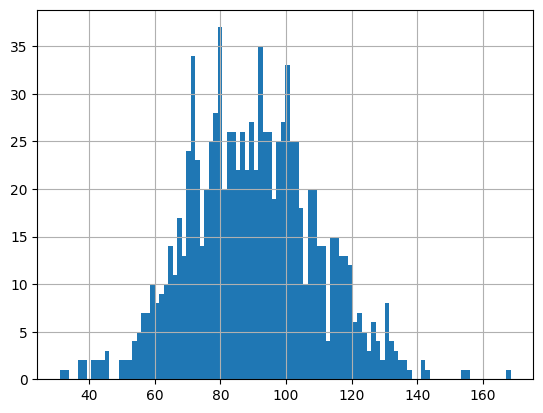

In [48]:
import numpy as np
import pandas as pd

# зададим точку отсчета
np.random.seed(12345)

values = np.random.normal(90, 20, 1000)
pd.Series(values).hist(bins=100)
print(values.mean())
print(values.std())
print(np.quantile(values, 0.9))
print(np.quantile(values, 0.1))

In [3]:
%pip install lightgbm

     ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
     ---- ----------------------------------- 0.1/1.0 MB 3.3 MB/s eta 0:00:01
     -------------- ------------------------- 0.4/1.0 MB 4.6 MB/s eta 0:00:01
     ---------------------------- ----------- 0.7/1.0 MB 6.7 MB/s eta 0:00:01
     ---------------------------------------- 1.0/1.0 MB 7.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
# подключение библиотек
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
import time
from IPython.display import display

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from lightgbm import LGBMRegressor

# константы
RST = 12345 # значение random_state

In [7]:
# загрузка файла
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except FileNotFoundError:
    data = pd.read_csv('D:\Education\Data_Science\Проекты курса DS\Проект_12\datasets\\taxi.csv', 
                            index_col=[0], parse_dates=[0])

# ресэмплинг по 1 часу
data = data.resample('1H').sum()

# обзор данных
data.info()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
# создание календарных признаков
data['dayofweek'] = data.index.dayofweek
data['month'] = data.index.month

# создание лагов
data['lag_1'] = data['num_orders'].shift(1) 
data['lag_24'] = data['num_orders'].shift(24) 
data['lag_48'] = data['num_orders'].shift(48) 
data['lag_168'] = data['num_orders'].shift(168) 

# создание скользящих средних
data['rolling_mean'] = data['num_orders'].shift().rolling(7).mean()

# удаление строк с пропусками
data = data.dropna()

# изменение типов данных
data.loc[:,['lag_1', 'lag_24', 'lag_48', 'lag_168']] = data.loc[:,['lag_1', 'lag_24', 'lag_48', 'lag_168']].astype('int64')

# просмотр результата
data.info()
display(pd.concat([data.head(5), data.sample(5)]))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4248 entries, 2018-03-08 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4248 non-null   int64  
 1   dayofweek     4248 non-null   int64  
 2   month         4248 non-null   int64  
 3   lag_1         4248 non-null   int64  
 4   lag_24        4248 non-null   int64  
 5   lag_48        4248 non-null   int64  
 6   lag_168       4248 non-null   int64  
 7   rolling_mean  4248 non-null   float64
dtypes: float64(1), int64(7)
memory usage: 298.7 KB


C:\Users\Victor\AppData\Local\Temp\ipykernel_3564\157635347.py:18: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,['lag_1', 'lag_24', 'lag_48', 'lag_168']] = data.loc[:,['lag_1', 'lag_24', 'lag_48', 'lag_168']].astype('int64')


,num_orders,dayofweek,month,lag_1,lag_24,lag_48,lag_168,rolling_mean
datetime,,,,,,,,
2018-03-08 00:00:00,143,3,3,94,100,42,124,86.000000
2018-03-08 01:00:00,78,3,3,143,121,75,85,99.571429
2018-03-08 02:00:00,65,3,3,78,24,36,71,96.571429
2018-03-08 03:00:00,68,3,3,65,66,49,66,98.714286
2018-03-08 04:00:00,60,3,3,68,73,30,43,97.571429
2018-06-16 23:00:00,103,5,6,74,91,119,114,82.000000
2018-08-17 17:00:00,165,4,8,204,191,165,138,132.000000
2018-04-18 11:00:00,63,2,4,84,78,81,93,46.714286
2018-07-06 04:00:00,75,4,7,57,89,104,95,106.428571


In [9]:
features = data.drop('num_orders', axis=1)
target = data['num_orders']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.1, 
                                                                            shuffle=False, random_state=RST)

print(f'''
Обучающая выборка (features_train, target_train):
    - признаки {features_train.shape};
    - целевой признак ({target_train.shape[0]}).
Тестовая выборка (features_test, target_test):
    - признаки {features_test.shape};
    - целевой признак ({target_test.shape[0]}).
''')


Обучающая выборка (features_train, target_train):
    - признаки (3823, 7);
    - целевой признак (3823).
Тестовая выборка (features_test, target_test):
    - признаки (425, 7);
    - целевой признак (425).



In [10]:
# скачивание библиотеки 'lazypredict'
%pip install lazypredict
# импортирование библиотеки и наборов для задач регрессии и классификации
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier

     ---------------------------------------- 0.0/70.9 MB ? eta -:--:--
     ---------------------------------------- 0.1/70.9 MB 3.0 MB/s eta 0:00:24
     ---------------------------------------- 0.3/70.9 MB 4.3 MB/s eta 0:00:17
     ---------------------------------------- 0.7/70.9 MB 6.8 MB/s eta 0:00:11
      --------------------------------------- 1.2/70.9 MB 7.5 MB/s eta 0:00:10
      --------------------------------------- 1.7/70.9 MB 8.8 MB/s eta 0:00:08
     - -------------------------------------- 2.1/70.9 MB 9.1 MB/s eta 0:00:08
     - -------------------------------------- 2.6/70.9 MB 9.8 MB/s eta 0:00:07
     - -------------------------------------- 3.1/70.9 MB 9.9 MB/s eta 0:00:07
     -- ------------------------------------- 3.6/70.9 MB 10.0 MB/s eta 0:00:07
     -- ------------------------------------- 4.1/70.9 MB 10.1 MB/s eta 0:00:07
     -- ------------------------------------- 4.6/70.9 MB 10.6 MB/s eta 0:00:07
     -- ------------------------------------- 5.1/70.9 M

In [11]:
# создание набора моделей для задач регрессии
mult_ML_model = LazyRegressor(verbose=0, ignore_warnings=True, predictions=True, random_state=RST)
models, predictions = mult_ML_model.fit(features_train, features_test, target_train, target_test)
model_dictionary = mult_ML_model.provide_models(features_train, features_test, target_train, target_test)
# отображение рассчитанных метрик моделей
display(models.sort_values(by='RMSE'))
# отображение предсказаний моделей
display(predictions)
# отображение pipeline и команд вызова отрабатываемых моделей
display(model_dictionary)

100%|██████████| 42/42 [20:08<00:00, 28.77s/it] 


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
SGDRegressor,0.64,0.65,34.91,0.02
MLPRegressor,0.64,0.65,34.91,4.01
Lars,0.64,0.65,35.05,0.02
LinearRegression,0.64,0.65,35.05,0.01
TransformedTargetRegressor,0.64,0.65,35.05,0.02
Ridge,0.64,0.65,35.06,0.01
OrthogonalMatchingPursuitCV,0.64,0.65,35.07,0.03
BayesianRidge,0.64,0.65,35.07,0.05
LassoLarsIC,0.64,0.65,35.08,0.02


,AdaBoostRegressor,BaggingRegressor,BayesianRidge,DecisionTreeRegressor,DummyRegressor,ElasticNet,ElasticNetCV,ExtraTreeRegressor,ExtraTreesRegressor,GaussianProcessRegressor,...,RANSACRegressor,RandomForestRegressor,Ridge,RidgeCV,SGDRegressor,SVR,TransformedTargetRegressor,TweedieRegressor,XGBRegressor,LGBMRegressor
0,54.26,41.80,46.76,45.00,79.56,54.72,47.26,31.00,39.80,65.08,...,23.63,40.71,46.72,46.77,47.47,48.32,46.72,60.09,35.52,40.48
1,86.91,87.30,87.35,113.00,79.56,88.23,87.46,90.00,93.67,21.60,...,77.10,88.46,87.34,87.35,88.22,86.35,87.33,89.16,90.03,84.77
2,126.85,119.10,118.82,122.00,79.56,113.10,118.46,144.00,122.78,132.76,...,117.74,119.68,118.84,118.82,119.86,114.38,118.84,110.43,99.70,108.05
3,125.38,102.80,117.21,85.00,79.56,115.42,117.41,83.00,110.98,184.59,...,118.68,109.67,117.19,117.22,118.38,108.40,117.18,113.59,104.69,96.13
4,92.86,89.30,98.04,102.00,79.56,101.83,98.79,70.00,92.46,252.92,...,100.35,88.31,97.98,98.05,99.11,90.03,97.97,102.24,110.66,104.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,117.60,118.50,134.32,215.00,79.56,130.44,134.26,136.00,147.87,123.82,...,122.41,141.66,134.32,134.32,135.40,99.04,134.32,127.69,149.50,146.59
421,162.23,160.50,174.47,168.00,79.56,157.68,173.05,132.00,169.01,83.03,...,158.37,171.69,174.56,174.45,176.12,109.63,174.58,149.95,177.11,162.47
422,164.77,177.20,175.39,175.00,79.56,161.02,174.32,122.00,177.94,145.77,...,159.49,180.41,175.46,175.37,177.49,108.04,175.47,153.64,193.68,181.49
423,164.77,185.50,206.16,216.00,79.56,179.07,203.61,178.00,178.00,37.86,...,186.04,186.63,206.32,206.11,207.98,96.92,206.35,167.64,202.23,178.96


{'AdaBoostRegressor': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('numeric',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer()),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   Index(['dayofweek', 'month', 'lag_1', 'lag_24', 'lag_48', 'lag_168',
        'rolling_mean'],
       dtype='object')),
                                                  ('categorical_low',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(fill_value='missing',
                                                                                  strategy='constant')),
                       

In [1]:
%pip install pandas_profiling

%pip install sweetviz

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pandas_profiling in c:\users\labrador\appdata\local\programs\python\python38\lib\site-packages (3.6.6)




[notice] A new release of pip is available: 23.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
import pandas as pd
import pandas_profiling
import ydata_profiling
from pandas_profiling import ProfileReport
import sweetviz as sv

In [15]:
file_path = 'D:\Education\Data Science\work\datasets\\titanic.txt'
data = pd.read_csv(file_path)

In [1]:
import psutil

# Get the current CPU usage
cpu_usage = psutil.cpu_percent()

# Get the current memory usage
memory_usage = psutil.virtual_memory().percent

# Get the current disk usage
disk_usage = psutil.disk_usage("/").percent

# Get the network activity
# Get the current input/output data rates for each network interface
io_counters = psutil.net_io_counters(pernic=True)
for interface, counters in io_counters.items():
    print(f"Interface {interface}:")
    print(f"  bytes sent: {counters.bytes_sent}")
    print(f"  bytes received: {counters.bytes_recv}")

# Get a list of active connections
connections = psutil.net_connections()
for connection in connections:
    print(f"{connection.laddr} <-> {connection.raddr} ({connection.status})")

# Print the collected data
print(f"CPU usage: {cpu_usage}%")
print(f"Memory usage: {memory_usage}%")
print(f"Disk usage: {disk_usage}%")


Interface Подключение по локальной сети 2:
  bytes sent: 0
  bytes received: 0
Interface Беспроводное сетевое соединение:
  bytes sent: 20704451
  bytes received: 236242348
Interface Подключение по локальной сети:
  bytes sent: 0
  bytes received: 0
Interface Loopback Pseudo-Interface 1:
  bytes sent: 0
  bytes received: 0
Interface isatap.{12CCD0D9-79C3-4267-AFEC-A382362AC199}:
  bytes sent: 0
  bytes received: 0
Interface isatap.{EF496908-4E57-4B6A-8E4A-2157BBBE078F}:
  bytes sent: 0
  bytes received: 0
Interface isatap.HomeLAN:
  bytes sent: 0
  bytes received: 0
addr(ip='127.0.0.1', port=51410) <-> addr(ip='127.0.0.1', port=49160) (TIME_WAIT)
addr(ip='127.0.0.1', port=51550) <-> addr(ip='127.0.0.1', port=51551) (ESTABLISHED)
addr(ip='127.0.0.1', port=51529) <-> () (LISTEN)
addr(ip='127.0.0.1', port=51535) <-> addr(ip='127.0.0.1', port=51534) (ESTABLISHED)
addr(ip='127.0.0.1', port=50793) <-> addr(ip='127.0.0.1', port=49160) (ESTABLISHED)
addr(ip='127.0.0.1', port=9001) <-> () (LIST